# Import Modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import math
import pandas as pd
import seaborn as sns
import os
import itertools
from glob import glob
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications.resnet_v2 import ResNet152V2
from tensorflow.keras.layers import Input, Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from keras.utils.np_utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, History
from sklearn.metrics import classification_report

from os.path import exists


Using TensorFlow backend.


# Creating a Dictionary of Images and their Labels

In [2]:
base_skin_dir = '.\\Documents\\Datasets\\'

In [3]:
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}
print(len(imageid_path_dict))

10015


In [4]:
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

# Load MetaData

In [5]:
skin_df = pd.read_csv(os.path.join(base_skin_dir, 'HAM10000_metadata'))

In [6]:
skin_df['path'] = skin_df['image_id'].map(imageid_path_dict.get) #Image Local Path
skin_df['cell_type'] = skin_df['dx'].map(lesion_type_dict.get) #Full 'dx' name
skin_df['cell_type_idx'] = pd.Categorical(skin_df['cell_type']).codes #Unique code for each 'dx'

In [7]:
skin_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern,.\Documents\Datasets\HAM10000_images_part_1\IS...,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern,.\Documents\Datasets\HAM10000_images_part_1\IS...,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern,.\Documents\Datasets\HAM10000_images_part_1\IS...,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern,.\Documents\Datasets\HAM10000_images_part_1\IS...,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern,.\Documents\Datasets\HAM10000_images_part_2\IS...,Benign keratosis-like lesions,2


In [8]:
len(skin_df)

10015

# Cleaning Dataset

In [9]:
skin_df = skin_df.drop_duplicates(subset='lesion_id')
skin_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern,.\Documents\Datasets\HAM10000_images_part_1\IS...,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern,.\Documents\Datasets\HAM10000_images_part_1\IS...,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern,.\Documents\Datasets\HAM10000_images_part_2\IS...,Benign keratosis-like lesions,2
6,HAM_0002761,ISIC_0029176,bkl,histo,60.0,male,face,vidir_modern,.\Documents\Datasets\HAM10000_images_part_1\IS...,Benign keratosis-like lesions,2
8,HAM_0005132,ISIC_0025837,bkl,histo,70.0,female,back,vidir_modern,.\Documents\Datasets\HAM10000_images_part_1\IS...,Benign keratosis-like lesions,2


 # Processing and Resizing Images

In [10]:
width = 64
height = 64
print("Width: ", width)
print("Height:", height)

Width:  64
Height: 64


In [11]:
skin_df['image'] = skin_df['path'].map(lambda x: np.asarray(Image.open(x).resize((int(width), int(height)))))

In [12]:
skin_df.head(5)

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,path,cell_type,cell_type_idx,image
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern,.\Documents\Datasets\HAM10000_images_part_1\IS...,Benign keratosis-like lesions,2,"[[[193, 156, 197], [188, 153, 193], [194, 145,..."
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern,.\Documents\Datasets\HAM10000_images_part_1\IS...,Benign keratosis-like lesions,2,"[[[185, 129, 138], [191, 135, 148], [199, 147,..."
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern,.\Documents\Datasets\HAM10000_images_part_2\IS...,Benign keratosis-like lesions,2,"[[[139, 94, 117], [160, 114, 140], [179, 134, ..."
6,HAM_0002761,ISIC_0029176,bkl,histo,60.0,male,face,vidir_modern,.\Documents\Datasets\HAM10000_images_part_1\IS...,Benign keratosis-like lesions,2,"[[[192, 147, 128], [193, 146, 140], [195, 148,..."
8,HAM_0005132,ISIC_0025837,bkl,histo,70.0,female,back,vidir_modern,.\Documents\Datasets\HAM10000_images_part_1\IS...,Benign keratosis-like lesions,2,"[[[101, 69, 70], [129, 89, 89], [148, 93, 99],..."


In [13]:
skin_df['image'].map(lambda x: x.shape).value_counts()

(64, 64, 3)    7470
Name: image, dtype: int64

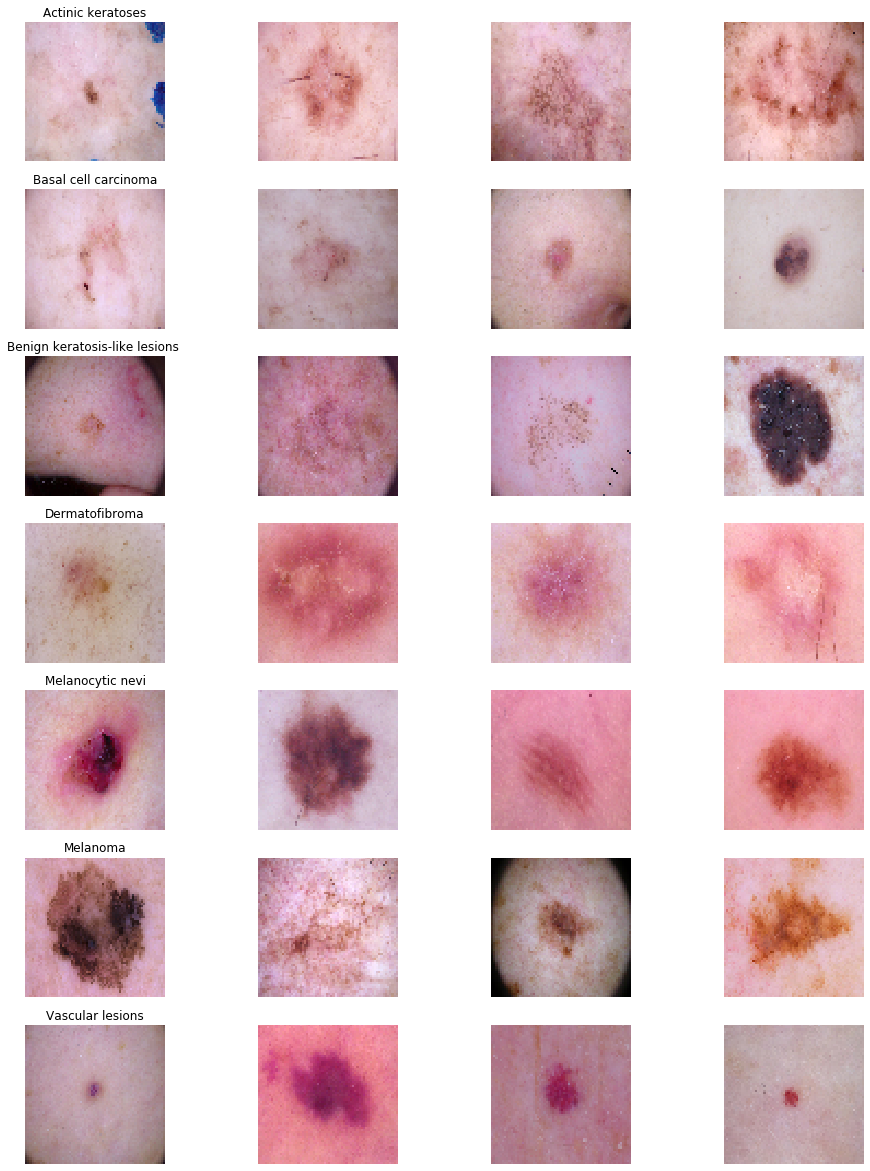

In [14]:
n_samples = 4
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, 
                                         skin_df.sort_values(['cell_type']).groupby('cell_type')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=2018).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')

if not exists('Photos3'):
    os.mkdir('Photos3')
fig.savefig('.//Photos3//category_samples.png', dpi=300)

# Features and Target Split

In [15]:
features=skin_df.drop(columns=['cell_type_idx'],axis=1)
target=skin_df['cell_type_idx']

# To Categorical

In [16]:
num_classes = 7
target_encoded = to_categorical(target, num_classes = num_classes)
print(target_encoded)

[[0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]


# Training, Validation, and Test Split

In [17]:
X_train, X_test, y_train, y_test = train_test_split(features, target_encoded, test_size=0.20, stratify=target_encoded)

In [18]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, stratify=y_train)

In [19]:
print(len(X_train))
print(len(X_test))
print(len(X_val))

5079
1494
897


# Feature Normalization

In [20]:
x_train_images = np.asarray(X_train['image'].tolist())
x_val_images = np.asarray(X_val['image'].tolist())
x_test_images = np.asarray(X_test['image'].tolist())

x_train_mean = np.mean(x_train_images)
x_train_std = np.std(x_train_images)

x_train_normalized = (x_train_images - x_train_mean)/x_train_std
x_val_normalized = (x_val_images - x_train_mean)/x_train_std
x_test_normalized = (x_test_images - x_train_mean)/x_train_std

# Reshaping Images

In [21]:
input_shape = (int(width), int(height), 3)
x_train_normalized = x_train_normalized.reshape(x_train_normalized.shape[0], * (input_shape))
x_val_normalized = x_val_normalized.reshape(x_val_normalized.shape[0], * (input_shape))
x_test_normalized = x_test_normalized.reshape(x_test_normalized.shape[0], * (input_shape))
x_train_normalized.shape

(5079, 64, 64, 3)

# Data Augmentation

In [22]:
augmented_data = ImageDataGenerator(featurewise_center=False, 
                                    samplewise_center=False, 
                                    featurewise_std_normalization=False, 
                                    samplewise_std_normalization=False, 
                                    zca_whitening=False, 
                                    zca_epsilon=1e-06, 
                                    rotation_range=20, 
                                    width_shift_range=0.2, 
                                    height_shift_range=0.2, 
                                    brightness_range=None, 
                                    shear_range=0.1, 
                                    zoom_range=0.1, 
                                    channel_shift_range=0.1, 
                                    fill_mode='nearest', 
                                    cval=0.0, 
                                    horizontal_flip=False, 
                                    vertical_flip=False, 
                                    rescale=None, 
                                    preprocessing_function=None, 
                                    data_format='channels_last')

# Create a CNN Model

In [64]:
inputs=Input((width, height, 3))
x = Conv2D(64, kernel_size=(3, 3), activation='relu', padding = 'Same')(inputs)
x = Conv2D(64, kernel_size=(3, 3), activation='relu', padding = 'Same')(x)
x = MaxPooling2D(2,2)(x);
x = Dropout(0.25)(x)

x = Conv2D(128, kernel_size=(3, 3), activation='relu', padding = 'Same')(x)
x = MaxPooling2D(2,2)(x);

x = Conv2D(256, kernel_size=(3, 3), activation='relu', padding = 'Same')(x)
x = MaxPooling2D(2,2)(x);

x = Conv2D(512, kernel_size=(3, 3), activation='relu', padding = 'Same')(x)
x = MaxPooling2D(2,2)(x);

x = Conv2D(64, kernel_size=(3, 3), activation='relu', padding = 'Same')(x)
x = MaxPooling2D(2,2)(x);

x = Flatten()(x)
x = Dense(128, activation="relu")(x)
x = Dense(32, activation="relu")(x)
outputs = Dense(7, activation="softmax")(x)
    
model1 = Model(inputs, outputs)
model1.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 64, 64)        1792      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 64, 64, 64)        36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 32, 32, 128)       73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 16, 16, 128)       0   

# Create a Pre-train VGG16 Model

In [24]:
basemodel = VGG16(input_shape=(width, height, 3), include_top = False)
basemodel.summary()
    
for layer in basemodel.layers:
    layer.trainable = False
     
inputs = basemodel.input   
x = basemodel.output
x = Dropout(0.25)(x)
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
outputs = Dense(7, activation='softmax')(x)
model2 = Model(inputs, outputs)
model2.summary()
    

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0     

# Create a Pre-train MobileNetV2

In [25]:
mobile = MobileNetV2(input_shape=(height, width, 3), include_top = False)
mobile.summary()

inputs = mobile.input;
x = mobile.layers[-6].output
x = Dropout(0.25)(x)
x = Flatten()(x)
outputs = Dense(7, activation='softmax')(x)
model3 = Model(inputs, outputs)
model3.summary()

for layer in model3.layers[:-23]:
    layer.trainable = False

C:\Users\HP\Anaconda3\lib\site-packages\keras_applications\mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 65, 65, 3)    0           input_3[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 32, 32, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 32, 32, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 65, 65, 3)    0           input_3[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 32, 32, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 32, 32, 32)   128         Conv1[0][0]                      
____________________________________________________________________________________________

# Create a Pre-train ResNet152V2

In [26]:
basemodel = ResNet152V2(input_shape=(height, width, 3), include_top = False)
basemodel.summary()

for layer in basemodel.layers:
    layer.trainable = False

inputs = basemodel.input;
x = basemodel.output
x = Dropout(0.4)(x)
x = Flatten()(x)
x = Dense(64, activation = 'sigmoid')(x)
outputs = Dense(7, activation='softmax')(x)
model4 = Model(inputs, outputs)
model4.summary()

Model: "resnet152v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 70, 70, 3)    0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 32, 32, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 34, 34, 64)   0           conv1_conv[0][0]                 
________________________________________________________________________________________

conv4_block5_preact_bn (BatchNo (None, 4, 4, 1024)   4096        conv4_block4_out[0][0]           
__________________________________________________________________________________________________
conv4_block5_preact_relu (Activ (None, 4, 4, 1024)   0           conv4_block5_preact_bn[0][0]     
__________________________________________________________________________________________________
conv4_block5_1_conv (Conv2D)    (None, 4, 4, 256)    262144      conv4_block5_preact_relu[0][0]   
__________________________________________________________________________________________________
conv4_block5_1_bn (BatchNormali (None, 4, 4, 256)    1024        conv4_block5_1_conv[0][0]        
__________________________________________________________________________________________________
conv4_block5_1_relu (Activation (None, 4, 4, 256)    0           conv4_block5_1_bn[0][0]          
__________________________________________________________________________________________________
conv4_bloc

conv4_block36_1_relu (Activatio (None, 4, 4, 256)    0           conv4_block36_1_bn[0][0]         
__________________________________________________________________________________________________
conv4_block36_2_pad (ZeroPaddin (None, 6, 6, 256)    0           conv4_block36_1_relu[0][0]       
__________________________________________________________________________________________________
conv4_block36_2_conv (Conv2D)   (None, 2, 2, 256)    589824      conv4_block36_2_pad[0][0]        
__________________________________________________________________________________________________
conv4_block36_2_bn (BatchNormal (None, 2, 2, 256)    1024        conv4_block36_2_conv[0][0]       
__________________________________________________________________________________________________
conv4_block36_2_relu (Activatio (None, 2, 2, 256)    0           conv4_block36_2_bn[0][0]         
__________________________________________________________________________________________________
max_poolin

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 70, 70, 3)    0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 32, 32, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 34, 34, 64)   0           conv1_conv[0][0]                 
____________________________________________________________________________________________

# Set Batch Size 

In [27]:
num_train_samples = len(x_train_normalized)
num_val_samples = len(x_val_normalized)
train_batch_size = 32
val_batch_size = 32
train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)
class_weights = None

# Training and Testing and Predicted Data Using AM-12

In [28]:
train_batches = augmented_data.flow(x_train_normalized, y_train, batch_size = train_batch_size)

valid_batches = augmented_data.flow(x_val_normalized, y_val, batch_size = val_batch_size)

test_batches = augmented_data.flow(x_test_normalized, y_test, batch_size = 1)

In [29]:
# Train model
model1.compile(loss = 'categorical_crossentropy', metrics=["accuracy", 'mse'], optimizer = Adam(learning_rate=0.001))
callbackList = [EarlyStopping(monitor = 'val_accuracy', patience = 10)]
history1 = model1.fit(train_batches, steps_per_epoch=train_steps, class_weight=class_weights,
                  validation_data=valid_batches,
                 	validation_steps=val_steps, callbacks=callbackList,epochs=20)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 159.0 steps, validate for 29.0 steps
Epoch 1/20
159/159 [==============================] - 168s 1s/step - loss: 0.8802 - accuracy: 0.7175 - mse: 0.0577 - val_loss: 0.7785 - val_accuracy: 0.7280 - val_mse: 0.0537
Epoch 2/20
159/159 [==============================] - 149s 935ms/step - loss: 0.7843 - accuracy: 0.7251 - mse: 0.0531 - val_loss: 0.7476 - val_accuracy: 0.7313 - val_mse: 0.0498
Epoch 3/20
159/159 [==============================] - 155s 978ms/step - loss: 0.7473 - accuracy: 0.7362 - mse: 0.0507 - val_loss: 0.7070 - val_accuracy: 0.7414 - val_mse: 0.0489
Epoch 4/20
159/159 [==============================] - 156s 981ms/step - loss: 0.7244 - accuracy: 0.7417 - mse: 0.0495 - val_loss: 0.6477 - val_accuracy: 0.7625 - val_mse: 0.0465
Epoch 5/20
159/159 [==============================] - 154s 969ms/step - loss: 0.6994 - accuracy: 0.7503 - mse: 0.0483 - val_loss: 0.6426 - val_accuracy: 0.7581 - val_mse: 0.0458
Epoch 6/20
159/1

In [30]:
test_loss, test_accuracy, test_mse = model1.evaluate(x_test_normalized, y_test, verbose=1)
print("\nTest Set Accuracy: ", test_accuracy*100,"%", 
          "\nTest Set Loss:", test_loss,
          "\nTest Set MSE:", test_mse)

1494/1494 [==============================] - 10s 7ms/sample - loss: 0.6106 - accuracy: 0.7798 - mse: 0.0428

Test Set Accuracy:  77.97858119010925 % 
Test Set Loss: 0.6105704657843154 
Test Set MSE: 0.04278508


In [33]:
if not exists('Models3'):
    os.mkdir('Models3')
model1.save('.//Models3//AM-12_Imbalanced.h5')
print("Saved entire model file to disk")

Saved entire model file to disk


# Training and Testing and Predicted Data Using VGG16

In [34]:
# Train model
model2.compile(loss = 'categorical_crossentropy', metrics=["accuracy", 'mse'], optimizer = Adam(learning_rate=0.001))
callbackList = [EarlyStopping(monitor = 'val_accuracy', patience = 10)]
history2 = model2.fit(train_batches, steps_per_epoch=train_steps, class_weight=class_weights,
                  validation_data=valid_batches,
                 	validation_steps=val_steps, callbacks=callbackList,epochs=20)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 159.0 steps, validate for 29.0 steps
Epoch 1/20
159/159 [==============================] - 81s 508ms/step - loss: 0.8377 - accuracy: 0.7352 - mse: 0.0537 - val_loss: 0.6809 - val_accuracy: 0.7659 - val_mse: 0.0463
Epoch 2/20
159/159 [==============================] - 78s 490ms/step - loss: 0.6857 - accuracy: 0.7519 - mse: 0.0472 - val_loss: 0.6395 - val_accuracy: 0.7547 - val_mse: 0.0450
Epoch 3/20
159/159 [==============================] - 79s 495ms/step - loss: 0.6486 - accuracy: 0.7687 - mse: 0.0452 - val_loss: 0.6415 - val_accuracy: 0.7670 - val_mse: 0.0452
Epoch 4/20
159/159 [==============================] - 104s 655ms/step - loss: 0.6172 - accuracy: 0.7769 - mse: 0.0435 - val_loss: 0.6230 - val_accuracy: 0.7637 - val_mse: 0.0443
Epoch 5/20
159/159 [==============================] - 89s 562ms/step - loss: 0.6143 - accuracy: 0.7757 - mse: 0.0434 - val_loss: 0.6069 - val_accuracy: 0.7781 - val_mse: 0.0426
Epoch 6/20
159/15

In [35]:
test_loss, test_accuracy, test_mse = model2.evaluate(x_test_normalized, y_test, verbose=1)
print("\nTest Set Accuracy: ", test_accuracy*100,"%", 
          "\nTest Set Loss:", test_loss,
          "\nTest Set MSE:", test_mse)

1494/1494 [==============================] - 31s 21ms/sample - loss: 0.6257 - accuracy: 0.7791 - mse: 0.0431

Test Set Accuracy:  77.91164517402649 % 
Test Set Loss: 0.6257057133688027 
Test Set MSE: 0.043131858


In [36]:
if not exists('Models3'):
    os.mkdir('Models3')
model2.save('.//Models3//VGG16_Imbalanced.h5')
print("Saved entire model file to disk")

Saved entire model file to disk


# Training and Testing and Predicted Data Using MobileNetV2

In [37]:
# Train model
model3.compile(loss = 'categorical_crossentropy', metrics=["accuracy", 'mse'], optimizer = Adam(learning_rate=0.001))
callbackList = [EarlyStopping(monitor = 'val_accuracy', patience = 10)]
history3= model3.fit(train_batches, steps_per_epoch=train_steps, class_weight=class_weights,
                  validation_data=valid_batches,
                 	validation_steps=val_steps, callbacks=callbackList,epochs=20)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 159.0 steps, validate for 29.0 steps
Epoch 1/20
159/159 [==============================] - 116s 729ms/step - loss: 1.1423 - accuracy: 0.6940 - mse: 0.0643 - val_loss: 2.2001 - val_accuracy: 0.7258 - val_mse: 0.0747
Epoch 2/20
159/159 [==============================] - 80s 505ms/step - loss: 0.8844 - accuracy: 0.7289 - mse: 0.0554 - val_loss: 2.1185 - val_accuracy: 0.5351 - val_mse: 0.1056
Epoch 3/20
159/159 [==============================] - 69s 434ms/step - loss: 0.7988 - accuracy: 0.7448 - mse: 0.0516 - val_loss: 1.9883 - val_accuracy: 0.7012 - val_mse: 0.0758
Epoch 4/20
159/159 [==============================] - 74s 466ms/step - loss: 0.7655 - accuracy: 0.7555 - mse: 0.0499 - val_loss: 1.7895 - val_accuracy: 0.7035 - val_mse: 0.0731
Epoch 5/20
159/159 [==============================] - 76s 479ms/step - loss: 0.7253 - accuracy: 0.7627 - mse: 0.0479 - val_loss: 1.6221 - val_accuracy: 0.7079 - val_mse: 0.0704
Epoch 6/20
159/15

In [38]:
test_loss, test_accuracy, test_mse = model3.evaluate(x_test_normalized, y_test, verbose=1)
print("\nTest Set Accuracy: ", test_accuracy*100,"%", 
          "\nTest Set Loss:", test_loss,
          "\nTest Set MSE:", test_mse)

1494/1494 [==============================] - 11s 7ms/sample - loss: 1.4310 - accuracy: 0.7062 - mse: 0.0708

Test Set Accuracy:  70.61579823493958 % 
Test Set Loss: 1.4309659805323385 
Test Set MSE: 0.07077945


In [39]:
if not exists('Models3'):
    os.mkdir('Models3')
model3.save('.//Models3//MobileNetV2_Imbalanced.h5')
print("Saved entire model file to disk")

Saved entire model file to disk


# Training and Testing and Predicted Data Using ResNet152V2

In [40]:
# Train model
model4.compile(loss = 'categorical_crossentropy', metrics=["accuracy", 'mse'], optimizer = Adam(learning_rate=0.001))
callbackList = [EarlyStopping(monitor = 'val_accuracy', patience = 10)]
history4 = model4.fit(train_batches, steps_per_epoch=train_steps, class_weight=class_weights,
                  validation_data=valid_batches,
                 	validation_steps=val_steps, callbacks=callbackList,epochs=20)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 159.0 steps, validate for 29.0 steps
Epoch 1/20
159/159 [==============================] - 348s 2s/step - loss: 0.9517 - accuracy: 0.7145 - mse: 0.0609 - val_loss: 1.0401 - val_accuracy: 0.7235 - val_mse: 0.0671
Epoch 2/20
159/159 [==============================] - 261s 2s/step - loss: 0.8316 - accuracy: 0.7269 - mse: 0.0540 - val_loss: 1.1298 - val_accuracy: 0.7235 - val_mse: 0.0697
Epoch 3/20
159/159 [==============================] - 258s 2s/step - loss: 0.7956 - accuracy: 0.7354 - mse: 0.0525 - val_loss: 1.1955 - val_accuracy: 0.7246 - val_mse: 0.0715
Epoch 4/20
159/159 [==============================] - 263s 2s/step - loss: 0.7737 - accuracy: 0.7381 - mse: 0.0516 - val_loss: 1.2369 - val_accuracy: 0.7235 - val_mse: 0.0719
Epoch 5/20
159/159 [==============================] - 256s 2s/step - loss: 0.7652 - accuracy: 0.7379 - mse: 0.0514 - val_loss: 1.2338 - val_accuracy: 0.7235 - val_mse: 0.0712
Epoch 6/20
159/159 [========

In [41]:
test_loss, test_accuracy, test_mse = model4.evaluate(x_test_normalized, y_test, verbose=1)
print("\nTest Set Accuracy: ", test_accuracy*100,"%", 
          "\nTest Set Loss:", test_loss,
          "\nTest Set MSE:", test_mse)

1494/1494 [==============================] - 57s 38ms/sample - loss: 1.3659 - accuracy: 0.7222 - mse: 0.0730

Test Set Accuracy:  72.22222089767456 % 
Test Set Loss: 1.3659436357228791 
Test Set MSE: 0.07295535


In [43]:
if not exists('Models3'):
    os.mkdir('Models3')
model4.save('.//Models3//ResNet152V2_Imbalanced.h5')
print("Saved entire model file to disk")

Saved entire model file to disk


# Testing Set Confusion Matrix for True vs Predicted Labels

In [44]:
def cal_true_pred_classes(model, x_test_normalized, y_test):
    #Predict the values from the testing set
    y_predict = model.predict(x_test_normalized)

    #Convert prediction classes to one hot vectors 
    y_predict_classes = np.argmax(y_predict, axis = 1) 

    #Convert testing label observations to one hot vectors
    y_true_classes = np.argmax(y_test, axis = 1) 
    
    return y_predict_classes, y_true_classes

In [45]:
def plot_confusion_matrix(cm, classes,
                          name,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.figure(figsize=(8,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(name)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True Labels')
    plt.xlabel('Predicted Labels')
    fig = plt
    fig.savefig('.//Photos3//' + name + '_confusion_matrix.png', dpi=300)

In [46]:
def create_confusion_matrix(model, x_test_normalized, y_test, cm_plot_labels, name):
    #Get the true and predicted labels
    y_predict_classes, y_true_classes = cal_true_pred_classes(model, x_test_normalized, y_test)

    #Compute the confusion matrix
    confusion_matrix_computed = confusion_matrix(y_true_classes, y_predict_classes)

    #Plot the confusion matrix
    plot_confusion_matrix(confusion_matrix_computed, cm_plot_labels, name) 

In [47]:
#Define the labels of the class indices. These need to match the order shown above.
cm_plot_labels=['akiec', 'bcc', 'bkl', 'df', 'nv','mel', 'vasc']

In [48]:
model1_name = "AM-12"
model2_name = "VGG16"
model3_name = "MobileNetV2"
model4_name = "ResNet152V2"

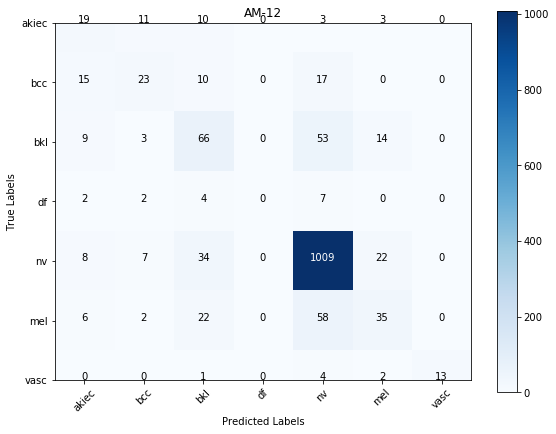

In [49]:
create_confusion_matrix(model1, x_test_normalized, y_test, cm_plot_labels, model1_name)

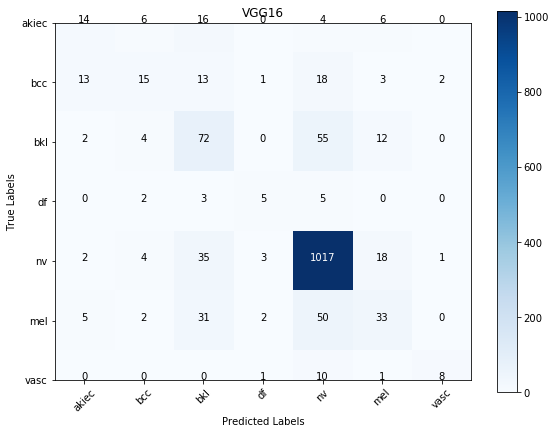

In [50]:
create_confusion_matrix(model2, x_test_normalized, y_test, cm_plot_labels, model2_name)

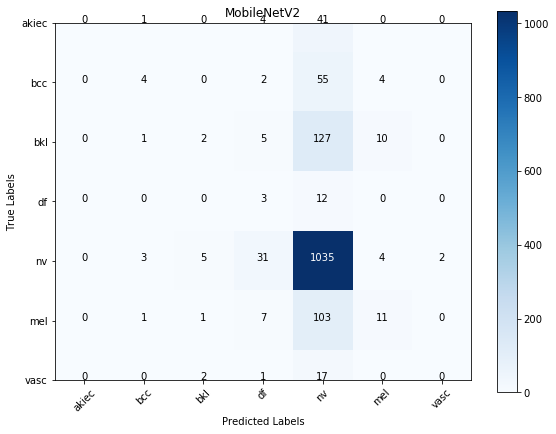

In [51]:
create_confusion_matrix(model3, x_test_normalized, y_test, cm_plot_labels, model3_name)

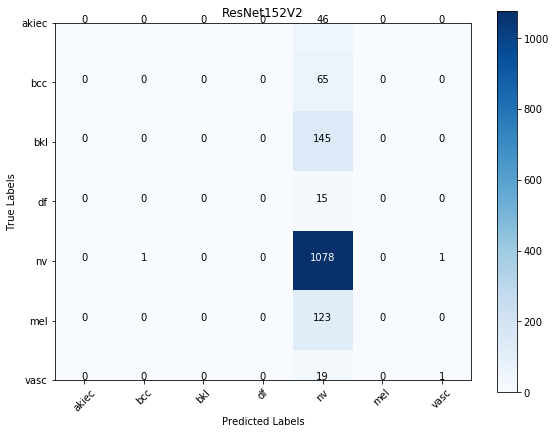

In [52]:
create_confusion_matrix(model4, x_test_normalized, y_test, cm_plot_labels, model4_name)

# Generate a Confusion Matrix Classification Report

In [53]:
def gen_classification_report(model, x_test_normalized, y_test, cm_plot_labels):
    
    #Get the true and predicted labels
    y_predict_classes, y_true_classes = cal_true_pred_classes(model, x_test_normalized, y_test)
    
    #Generate report
    report = classification_report(y_true_classes, y_predict_classes, target_names = cm_plot_labels)
    print(report)

In [54]:
gen_classification_report(model1, x_test_normalized, y_test, cm_plot_labels)

              precision    recall  f1-score   support

       akiec       0.32      0.41      0.36        46
         bcc       0.48      0.35      0.41        65
         bkl       0.45      0.46      0.45       145
          df       0.00      0.00      0.00        15
          nv       0.88      0.93      0.90      1080
         mel       0.46      0.28      0.35       123
        vasc       1.00      0.65      0.79        20

    accuracy                           0.78      1494
   macro avg       0.51      0.44      0.47      1494
weighted avg       0.76      0.78      0.77      1494



C:\Users\HP\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\HP\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\HP\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [55]:
gen_classification_report(model2, x_test_normalized, y_test, cm_plot_labels)

              precision    recall  f1-score   support

       akiec       0.39      0.30      0.34        46
         bcc       0.45      0.23      0.31        65
         bkl       0.42      0.50      0.46       145
          df       0.42      0.33      0.37        15
          nv       0.88      0.94      0.91      1080
         mel       0.45      0.27      0.34       123
        vasc       0.73      0.40      0.52        20

    accuracy                           0.78      1494
   macro avg       0.53      0.42      0.46      1494
weighted avg       0.76      0.78      0.76      1494



In [56]:
gen_classification_report(model3, x_test_normalized, y_test, cm_plot_labels)

              precision    recall  f1-score   support

       akiec       0.00      0.00      0.00        46
         bcc       0.40      0.06      0.11        65
         bkl       0.20      0.01      0.03       145
          df       0.06      0.20      0.09        15
          nv       0.74      0.96      0.84      1080
         mel       0.38      0.09      0.14       123
        vasc       0.00      0.00      0.00        20

    accuracy                           0.71      1494
   macro avg       0.25      0.19      0.17      1494
weighted avg       0.61      0.71      0.63      1494



C:\Users\HP\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\HP\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\HP\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [57]:
gen_classification_report(model4, x_test_normalized, y_test, cm_plot_labels)

              precision    recall  f1-score   support

       akiec       0.00      0.00      0.00        46
         bcc       0.00      0.00      0.00        65
         bkl       0.00      0.00      0.00       145
          df       0.00      0.00      0.00        15
          nv       0.72      1.00      0.84      1080
         mel       0.00      0.00      0.00       123
        vasc       0.50      0.05      0.09        20

    accuracy                           0.72      1494
   macro avg       0.17      0.15      0.13      1494
weighted avg       0.53      0.72      0.61      1494



C:\Users\HP\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\HP\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\HP\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Plot the Models History

In [58]:
def plot_model_history(model_history, name):
    
    fig = plt.figure()

    #Summarize history for accuracy
    ax1 = plt.subplot(1,2,1) 
    ax1.plot(range(1,len(model_history.history['accuracy'])+1),model_history.history['accuracy'])
    ax1.plot(range(1,len(model_history.history['val_accuracy'])+1),model_history.history['val_accuracy'])
    ax1.set_title('Model Accuracy')
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_xticks(np.arange(1,len(model_history.history['accuracy'])+1),len(model_history.history['accuracy'])/10)
    ax1.legend(['train', 'validation'], loc='best')
    
    #Summarize history for loss
    ax2 = plt.subplot(1,2,2) 
    ax2.plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    ax2.plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    ax2.set_title('Model Loss')
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    ax2.legend(['train', 'validation'], loc='best')
    
    #Plot and save figures
    plt.show()
    fig.savefig('.//Photos3//' + name + '_model_history.png', dpi=300)

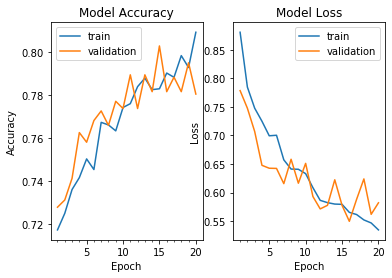

In [59]:
plot_model_history(history1, "AM-12")

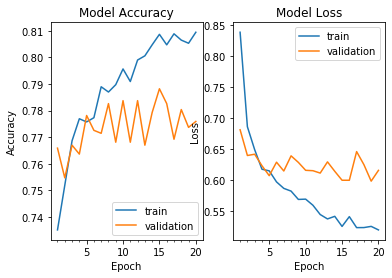

In [60]:
plot_model_history(history2, "VGG16")

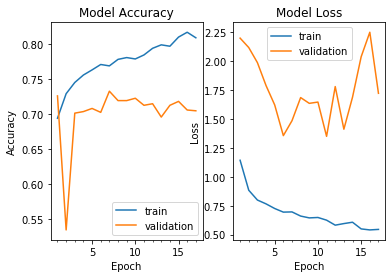

In [61]:
plot_model_history(history3, "MobileNetV2")

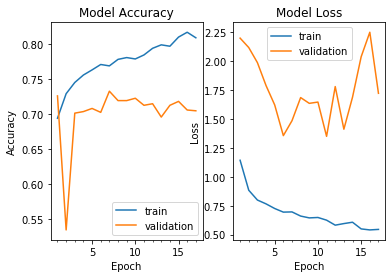

In [62]:
plot_model_history(history3, "ResNet152V2")